In [2]:
#!/usr/bin/env python
# coding: utf-8

# # Common neighbor bias, the second
# In the first part of this exercise, we found that neurons in a local circuit tend to have more (graph-theoretical) "common neighbors" than expected, even when compared to a powerful control case. But Perin et al., 2011 found also another trend: Neuron pairs with many common neighbors are more likely to be connected to each other than pairs with few. In other words, the connection probability depends on the number of common neighbors of a pair.
# ![CN2.PNG](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2.png)

# And as before, we will see if we can find this tendency in an in-silico hippocampal microcircuit. Once more, we want analyze this tendency on a much more global scale than sampling 8 neurons at a time. 
# We begin with the same basic steps as in the first part: 
# Import relevant packages, load a circuit, define a sample population of excitatory neurons and extract their connection matrix.
# (for details, see "Common neighbor bias, the first").

# In[1]:
import numpy
import json

from matplotlib import pyplot as plt
from scipy import sparse
from scipy.stats import hypergeom
from scipy import spatial
from bluepysnap import Circuit
from tqdm import tqdm

# In[2]:


circuit_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json'
circuit = Circuit(circuit_path)
cells = circuit.nodes["hippocampus_neurons"]
conn = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical_synapse"]


# In[3]:


def efferent_con_mat(pop_gids):
    '''Returns a sparse matrix of the EFFERENT connectivity of neurons in
    the specified population'''
    shape = (len(pop_gids), cells.size) # The output shape is (number of neurons in population x number of neurons in circuit)
    
    post = [conn.efferent_nodes(_g) for _g in tqdm(pop_gids)]  # Get identifiers of connected neurons
    '''prepare the sparse matrix representation, where the column indices for row i are stored in
    "indices[indptr[i]:indptr[i+1]]" and their corresponding values are stored in "data[indptr[i]:indptr[i+1]]".'''
    indptr = numpy.hstack((0, numpy.cumsum(list(map(len, post)))))
    indices = numpy.hstack(post)
    data = numpy.ones_like(indices, dtype=bool) # Simple boolean connection matrix. A connection exists or not.
    return sparse.csr_matrix((data, indices, indptr), shape=shape)



In [16]:
dpi=300
file_format = 'png'

In [3]:

# Now for this example, we will do something slightly different. As mentioned, we want to see whether the connection probability increases with the number of common neighbors. But because connectivity is directed, we can go one step further: We can also analyze how this increase depends on the direction of the connection.
# ![CN2b.PNG](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2b.png)
# 
# For this, we consider the number of common neighbors between two different populations, in the illustration above indicated by the blue star and the black circle. We can consider the number of commonn neighbors between pairs of neurons where one neuron is in the "star" population and the other in the "circle" population and then evaluate separately how this influences the connection probability from star to circle and from circle to star.
# 
# Here, we use the excitatory and inhibitory sub-populations.

# In[4]:


analyze_population1 = 'Excitatory'
analyze_population2 = 'Inhibitory'

n_smpl_population = 2500
analyze_gids1 = cells.ids(analyze_population1, sample=n_smpl_population)
analyze_gids1.sort()

# analyze_gids2 = cells.ids(analyze_population2, sample=n_smpl_population)

connections1 = efferent_con_mat(analyze_gids1)
# connections2 = efferent_con_mat(analyze_gids2)



  0%|          | 207/49712 [02:39<10:40:03,  1.29it/s]

KeyboardInterrupt: 

In [4]:
analyze_gids2 = cells.ids(analyze_population2, sample=n_smpl_population)
analyze_gids2.sort()
connections2 = efferent_con_mat(analyze_gids2)


100%|██████████| 2500/2500 [14:44<00:00,  2.83it/s]


In [5]:
print (connections1.shape, connections2.shape)

(2500, 456378) (2500, 456378)


(2500, 2500)


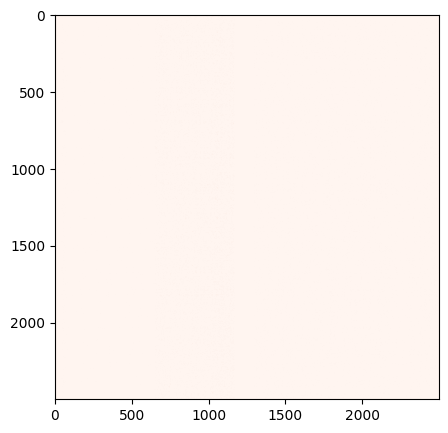

In [6]:

# Because we can calculate the number of common neighbors with a matrix multiplication, we have to change the code very little. Simply instead of multiplying a connection matrix with its transpose, we multiply one matrix with the transpose other. The result is a matrix of the number of common neighbors for all pairs of the two populations.

# In[5]:


def common_efferent_neighbors(M, *args):
    if len(args) == 0: # No second matrix provided: Default to the early use case, com. neighs. within the population
        return common_efferent_neighbors(M, M)
    M2 = args[0]
    assert M.shape[1] == M2.shape[1]
    CN = M.astype(int) * M2.astype(int).transpose() # Our new use case: com. neighs. for pairs of the two populations
    return CN.toarray()

com_neighs = common_efferent_neighbors(connections1, connections2)
print(com_neighs.shape)
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.imshow(com_neighs, cmap='Reds');


In [7]:


# Unlike earlier, this matrix is no longer symmetrical and it does not have the large entries along the main diagonal. This is because the two populations are disjunct, so we never evaluate the number of common neighbors between a neuron and itself.
# 
# Next, we need the connectivity between the two defined populations. Luckily, we already have the connectivity from population1 to everything (and also from population2 to everything), so we can get the required connection matrices as a sub-matrices of that. We will get two such matrices, one each for the analysis of increased connection probability in either direction.

# In[6]:


con_1_to_2 = connections1[:, analyze_gids2] # minus 1 because neuron gids start counting at 0.
con_2_to_1 = connections2[:, analyze_gids1].transpose() # transpose because we need population 1 to be along the first axis.


# With all of this, we can now plot how the connection probability in either direction depends on the number of common neighbors between pairs of neurons of the two populations. We define a minimum of 10 connections to be sampled to establish a proper probability.


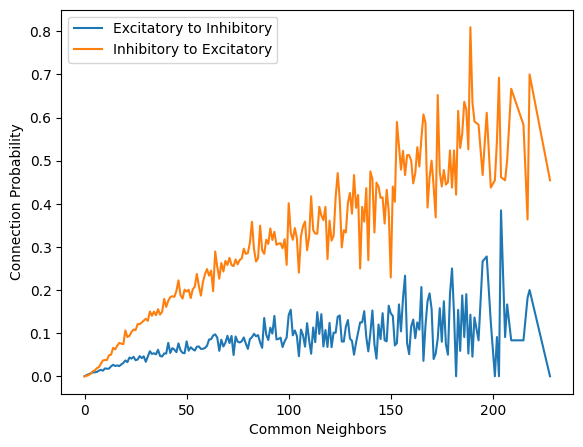

In [19]:
def con_prob_for_common_neighbors(cn_mat, connections, min_connections=10):
    cn_x = numpy.unique(cn_mat)
    smpls = [connections[cn_mat == i] for i in cn_x]
    result = [(x, y.mean()) for x, y in zip(cn_x, smpls)
              if numpy.prod(y.shape) >= min_connections]
    return zip(*result)

x1, y1 = con_prob_for_common_neighbors(com_neighs, con_1_to_2)
x2, y2 = con_prob_for_common_neighbors(com_neighs, con_2_to_1)
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x1, y1, label='%s to %s' % (analyze_population1, analyze_population2))
ax.plot(x2, y2, label='%s to %s' % (analyze_population2, analyze_population1))
ax.legend();
plt.xlabel('Common Neighbors')
plt.ylabel('Connection Probability')
plt.savefig(f"../output/common_neighbors/cn_conn_prob_bias_ei_vs_ER.png", dpi=dpi, bbox_inches='tight')

In [10]:

nbins = 50

def connect_keep_dist_dep(D, C, nbins):
    '''Randomly connect a number of neurons, keeping their distance dependence intact.
    D: Matrix (AxN) of distances to all other neurons in the circuit
    C: Matrix (AxN) of connections to all other neurons in the circuit (boolean)'''
    dbins = numpy.linspace(0, D.max(), nbins + 1) + 0.1
    Di = numpy.digitize(D, bins=dbins) - 1
    H_connected = numpy.histogram(Di[C.toarray()], bins=range(nbins + 1))[0]
    H_all = numpy.histogram(Di, bins=range(nbins + 1))[0]
    P = H_connected.astype(float) / H_all
    n_eff = numpy.array(C.sum(axis=1)).transpose()[0]
    indptr = [0]
    indices = []
    for row, n in zip(Di, n_eff):
        p_row = P[row]
        p_row[row == -1] = 0
        p_row = p_row / p_row.sum()
        rnd = numpy.random.choice(len(row), n, replace=False, p=p_row)
        indices.extend(rnd)
        indptr.append(indptr[-1] + n)
    data = numpy.ones_like(indices, dtype=bool)
    return sparse.csr_matrix((data, indices, indptr), shape=D.shape)

xyz = cells.positions()
# get distance matrix as an input
D1 = spatial.distance_matrix(xyz.loc[analyze_gids1], xyz)
D2 = spatial.distance_matrix(xyz.loc[analyze_gids2], xyz)

rnd_connections1 = connect_keep_dist_dep(D1, connections1, nbins)
rnd_connections2 = connect_keep_dist_dep(D2, connections2, nbins)

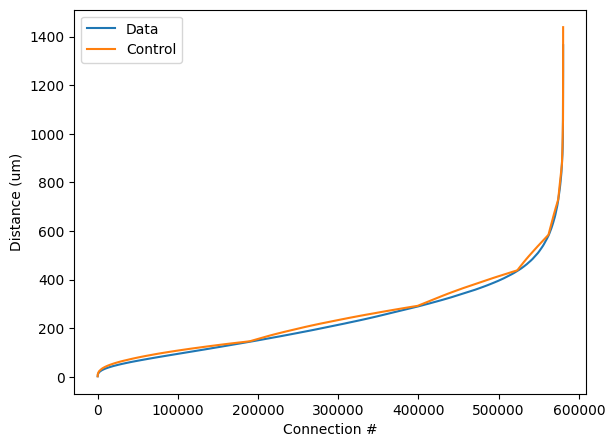

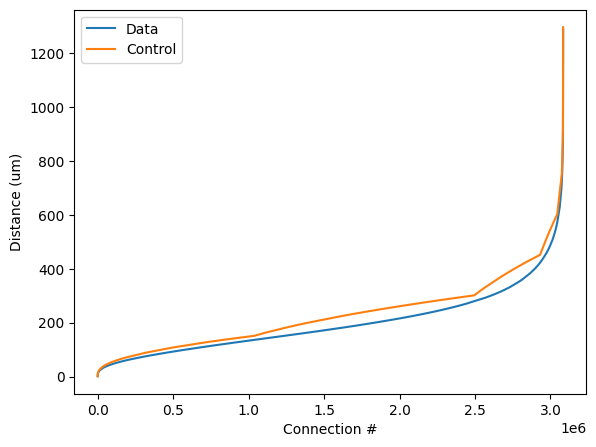

In [18]:

# compare distribution of distances of connected neurons
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(sorted(D1[connections1.toarray()]), label='Data')
ax.plot(sorted(D1[rnd_connections1.toarray()]), label='Control')
ax.legend(); ax.set_xlabel('Connection #'); ax.set_ylabel('Distance (um)')
plt.savefig(f"../output/common_neighbors/dd_exc_num_cells.png", dpi=dpi, bbox_inches='tight')

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(sorted(D2[connections2.toarray()]), label='Data')
ax.plot(sorted(D2[rnd_connections2.toarray()]), label='Control')
ax.legend(); ax.set_xlabel('Connection #'); ax.set_ylabel('Distance (um)');
plt.savefig(f"../output/common_neighbors/dd_inh_num_cells.png", dpi=dpi, bbox_inches='tight')

# Now we analyze if and how the connection probability in the controls depends on the number of common neighbors.


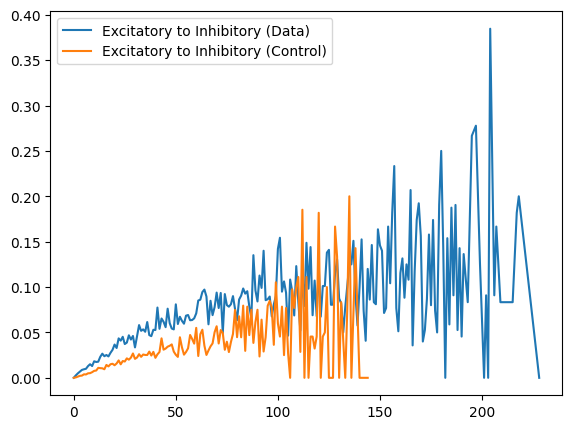

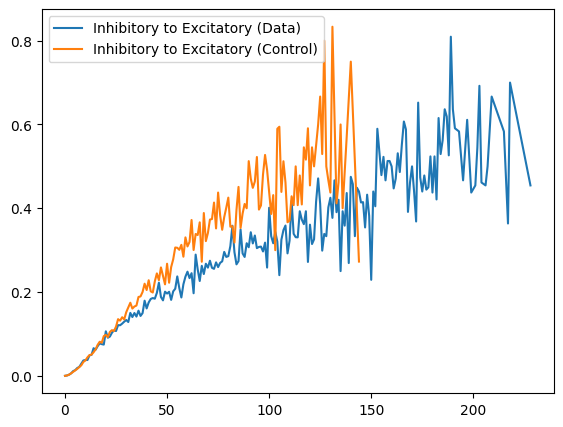

In [12]:

# In[9]:


rnd_com_neighs = common_efferent_neighbors(rnd_connections1, rnd_connections2)
rnd_con_1_to_2 = rnd_connections1[:, analyze_gids2]
rnd_con_2_to_1 = rnd_connections2[:, analyze_gids1].transpose()
rnd_x1, rnd_y1 = con_prob_for_common_neighbors(rnd_com_neighs, rnd_con_1_to_2)
rnd_x2, rnd_y2 = con_prob_for_common_neighbors(rnd_com_neighs, rnd_con_2_to_1)

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x1, y1, label='%s to %s (Data)' % (analyze_population1, analyze_population2))
ax.plot(rnd_x1, rnd_y1, label='%s to %s (Control)' % (analyze_population1, analyze_population2))
ax.legend()
plt.xlabel('Common Neighbors')


plt.savefig(f"../output/common_neighbors/cn_conn_prob_bias_ei_vs_dd.png", dpi=dpi, bbox_inches='tight')

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x2, y2, label='%s to %s (Data)' % (analyze_population2, analyze_population1))
ax.plot(rnd_x2, rnd_y2, label='%s to %s (Control)' % (analyze_population2, analyze_population1))
ax.legend();
plt.savefig(f"../output/common_neighbors/cn_conn_prob_bias_ie_vs_dd.png", dpi=dpi, bbox_inches='tight')




We see that the bias for increased connectivity between neurons with many common neighbors is better explained by the control in one direction than the other. The effect on top of the one caused by distance dependence is much stronger from excitatory to inhibitory. In fact for the inhibitory to excitatory direction the control depicts a stronger increase than the data. Fascinating!

As before, let us define a metric that captures this tendency. This is inspired by the clustering coefficient, which is defined as the fraction of closed triangle motifs, where a triangle motif consists of a pair of neurons and a common neighbor and it is considered closed if the pair is connected as well.
![Sketch_CN2c.png](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2c.png)

Consequently, we count the number of common efferent neighbors of connected neurons (closed triangles) and divide it by the number of common efferent neighbors overall (all triangles). And we can do this analysis separately for the excitatory to inhibitory and inhibitory to excitatory directions.
![Sketch_CN2d.png](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2d.png)

The result is then normalized with respect to our strong control. For a proper analysis we should generate more than one control, but for this example we keep it at one.

Text(0, 0.5, 'Normalized CC')

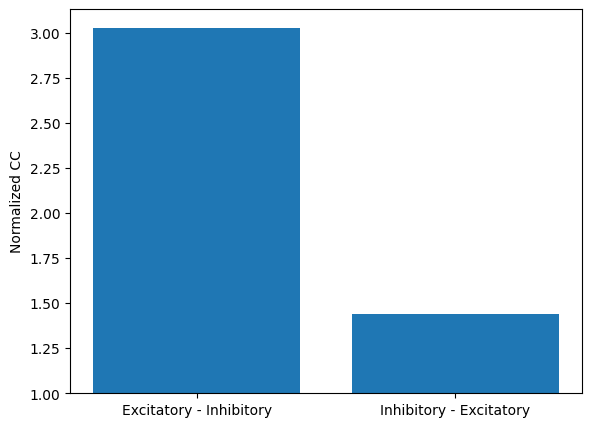

In [13]:
def cn_cluster_coefficient(cn_mat, connections):
    num_closed = cn_mat[connections.toarray()].sum()
    num_total = cn_mat.sum()
    return float(num_closed) / num_total

CC_1_to_2 = cn_cluster_coefficient(com_neighs, con_1_to_2)
CC_2_to_1 = cn_cluster_coefficient(com_neighs, con_2_to_1)
CC_1_to_2_nrmlz = CC_1_to_2 / cn_cluster_coefficient(rnd_com_neighs, rnd_con_1_to_2)
CC_2_to_1_nrmlz = CC_2_to_1 / cn_cluster_coefficient(rnd_com_neighs, rnd_con_2_to_1)

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
'''For plotting, we let the bars start at a value of 1, since that
is the value indicating no effect (bottom=1). To compensate, we have
to subtract 1 from the height of the bars.'''
ax.bar([1, 2], [CC_1_to_2_nrmlz - 1, CC_2_to_1_nrmlz - 1], bottom=1)
ax.set_xticks([1, 2])
ax.set_xticklabels(["%s - %s" % lbl for lbl in [(analyze_population1, analyze_population2),
                                               (analyze_population2, analyze_population1)]])
ax.set_ylabel("Normalized CC")

Disynaptic inhibition of innervated neurons (data, control):  0.47526833554433784 0.1482745550712403
Overall disynaptic inhibition (data, control):  0.006681030198651211 0.0034083974249416536


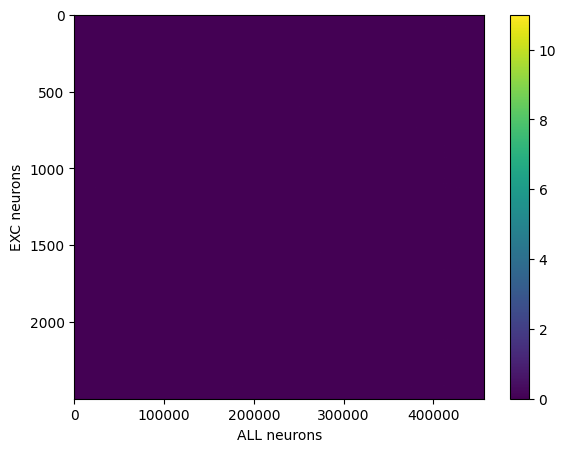

In [14]:
disynaptic = con_1_to_2.astype(int) * connections2.astype(int)
rnd_disynaptic = rnd_con_1_to_2.astype(int) * rnd_connections2.astype(int)
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
plt.colorbar(ax.imshow(disynaptic.toarray(), aspect='auto'))
ax.set_xlabel('ALL neurons'); ax.set_ylabel("EXC neurons")
print("Disynaptic inhibition of innervated neurons (data, control): ", disynaptic[connections1].mean(), rnd_disynaptic[rnd_connections1].mean())
print("Overall disynaptic inhibition (data, control): ", disynaptic.mean(), rnd_disynaptic.mean())
